In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
import shap
import pickle

# Loading dataset
df = pd.read_csv("synthetic_health_data.csv")
df.dropna(inplace=True)  # Drop missing values

In [4]:
# Encode categorical variables
categorical_cols = ["Ethnicity", "Region", "Menstrual Health", "Reproductive Health", "Medications"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [5]:
# Save label encoders for consistency with future data
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)

In [6]:
# Standardize numerical features
scaler = StandardScaler()
numerical_cols = ["Age", "Diet Quality", "Stress Levels", "BMI", "Systolic BP", "Diastolic BP", 
                  "Cholesterol", "Sleep (hours)", "Exercise (hours/week)", "Doctor Visits (per year)"]
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [7]:
# Save the scaler for future use
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

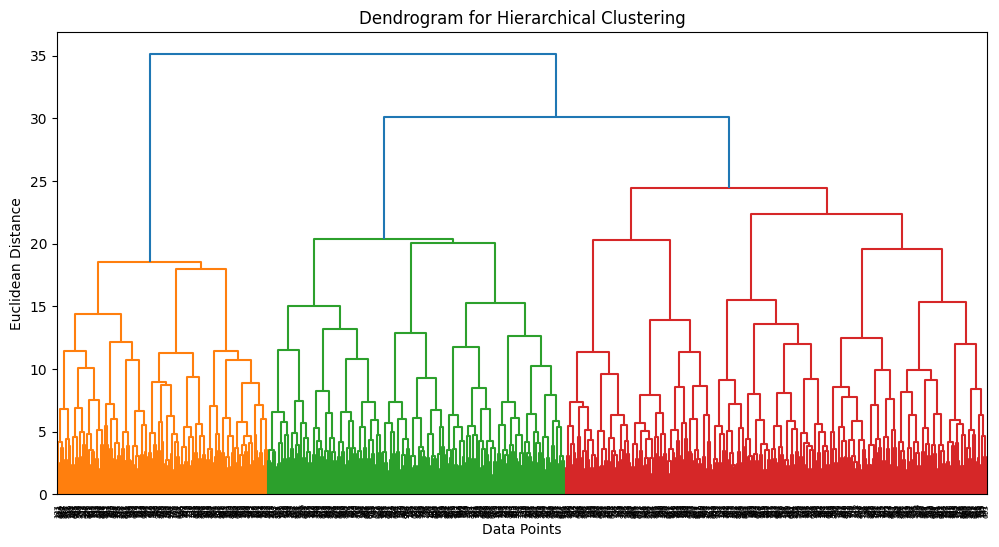

In [8]:
# Hierarchical Clustering (using a sample for efficiency)
sample_df = df.sample(n=1000, random_state=42)
Z = linkage(sample_df[numerical_cols], method="ward")
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Euclidean Distance")
plt.show()

In [9]:
# Agglomerative Clustering (with KNN propagation)
sample_df = df.sample(n=5000, random_state=42)
hc = AgglomerativeClustering(n_clusters=3)
sample_clusters = hc.fit_predict(sample_df[numerical_cols])
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(sample_df[numerical_cols], sample_clusters)
df["Hierarchical Cluster"] = knn.predict(df[numerical_cols])

In [12]:
# Gaussian Mixture Model Clustering
lowest_bic = np.inf
best_gmm = None
for n in range(2, 6): 
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(df[numerical_cols])
    bic = gmm.bic(df[numerical_cols])
    if bic < lowest_bic:
        lowest_bic = bic
        best_gmm = gmm
df["GMM Cluster"] = best_gmm.predict(df[numerical_cols])

In [13]:
# Final Cluster Selection
df["Final Cluster"] = df["Hierarchical Cluster"] 

In [14]:
# Improved Healthcare Recommendation Function
def recommend_healthcare(cluster, bmi, bp, sleep, stress, medications):
    bmi_threshold = np.percentile(df["BMI"], 75)  # More meaningful threshold
    bp_threshold = np.percentile(df["Systolic BP"], 75)
    stress_threshold = np.percentile(df["Stress Levels"], 75)
    
    if cluster == 0:
        return "Regular exercise, balanced diet, annual checkups."
    elif cluster == 1:
        if bmi > bmi_threshold:
            return "Medical checkup needed, focus on weight and BP management."
        elif bp > bp_threshold:
            return "Monitor BP, reduce salt, and regular exercise."
        elif stress > stress_threshold:
            return "Stress management techniques: Meditation, yoga."
        elif medications:
            return "Monitor medication side effects, follow doctor's advice."
        else:
            return "Frequent monitoring and preventive healthcare."
    else:
        return "High risk: Immediate medical consultation required."

In [15]:
df["Health Recommendation"] = df.apply(
    lambda x: recommend_healthcare(x["Final Cluster"], x["BMI"], x["Systolic BP"], 
                                   x["Sleep (hours)"], x["Stress Levels"], x["Medications"]), axis=1)

In [16]:
# Train Random Forest Classifier to Predict Clusters
X = df[numerical_cols]
y = df["Final Cluster"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Model Evaluation
y_pred = model.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Model Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      5811
           1       0.78      0.67      0.72      2249
           2       0.81      0.75      0.78      1940

    accuracy                           0.83     10000
   macro avg       0.81      0.78      0.80     10000
weighted avg       0.83      0.83      0.83     10000

Confusion Matrix:
 [[5349  275  187]
 [ 574 1514  161]
 [ 332  153 1455]]


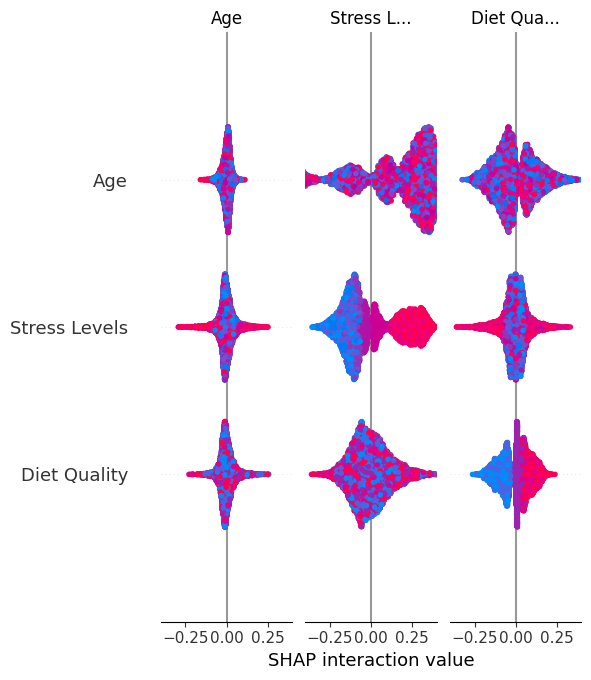

In [18]:
# Explainability using SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [19]:
# Save trained model
with open("health_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [20]:
# Save processed dataset
df.to_csv("healthcare_recommendations.csv", index=False)

print("✅ Optimized ML pipeline with explainability successfully completed!")

✅ Optimized ML pipeline with explainability successfully completed!
